# Imports

In [ ]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torch import tensor
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_ae as trainer
from data import get_data
from models import get_model
from tester_ae import tester_ae
from loss import *

In [ ]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load Data 

In [3]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'
model_name = 'AE'
batch_size = 128

In [ ]:
dl_train, dl_valid, dl_test = get_data(model_name=model_name, dataset_name=dataset_name, batch_size=batch_size, device=device)

## Find Spots Neighbors

In [56]:
df_spots = obj.obs[['array_row', 'array_col']].reset_index(drop=False).rename(columns={'index': 'spot_name'})
df_spots[['spot_encoding']] = oe_spots.transform(df_spots[['spot_name']].values)
df_spots['spot_encoding'] = df_spots['spot_encoding'].astype(int)
df_spots.head(2)

,spot_name,array_row,array_col,spot_encoding
0,AAACAAGTATCTCCCA-1,50,102,0
1,AAACCGGGTAGGTACC-1,42,28,1


In [158]:
def find_spots_neighbors(spot_encoding):   
    # Get spot location
    mask = df_spots['spot_encoding'] == spot_encoding
    row, col = df_spots.loc[mask, ['array_row', 'array_col']].values[0]
    
    # Get 1st degree neighbors
    first_degree_neighbors = []
    first_degree_tuples = [(2, 0), (-2, 0), (0, 2), (0, -2)]
    for tup in first_degree_tuples:
        mask = (df_spots['array_row'] == row+tup[0]) & (df_spots['array_col'] == col+tup[1])
        neighbor_encoding = df_spots.loc[mask, 'spot_encoding'].values
        if neighbor_encoding.size > 0:
            first_degree_neighbors.append(neighbor_encoding[0])
    
    # Get 1st degree neighbors
    second_degree_neighbors = []
    second_degree_tuples = [(4, 0), (-4, 0), (0, 4), (0, -4), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    for tup in second_degree_tuples:
        mask = (df_spots['array_row'] == (row+tup[0])) & (df_spots['array_col'] == (col+tup[1]))
        neighbor_encoding = df_spots.loc[mask, 'spot_encoding'].values
        if neighbor_encoding.size > 0:
            second_degree_neighbors.append(neighbor_encoding[0])
   
    return first_degree_neighbors, second_degree_neighbors
    

find_spots_neighbors(spot_encoding=0)

([219, 329], [791, 637, 1148, 154, 662])

In [159]:
# Create spots-spots matrix
n_spots = df_spots.shape[0]
df_spots_neighbors = pd.DataFrame(np.zeros(shape=(n_spots, n_spots)))

for spot_encoding in range(n_spots):
    first_degree_neighbors, second_degree_neighbors = find_spots_neighbors(spot_encoding=spot_encoding)

    if first_degree_neighbors:
        df_spots_neighbors.iloc[spot_encoding, first_degree_neighbors] = 1
    
    if second_degree_neighbors:
        df_spots_neighbors.iloc[spot_encoding].iloc[second_degree_neighbors] = 2

display(df_spots_neighbors.head())
print(np.unique(df_spots_neighbors.values, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,...,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([0., 1., 2.]), array([1390929,    4494,    8802]))


<AxesSubplot:>

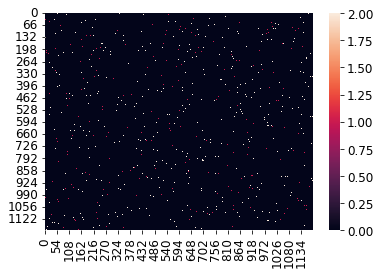

In [160]:
sns.heatmap(data=df_spots_neighbors)

# Load Model

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "SGD",
    'latent_dim': 10,
    'batch_size': batch_size
}

: 

In [ ]:
model = get_model(model_name=model_name, params=params, dl_train=dl_train)

# Train Model 

In [ ]:
max_epochs = 5
early_stopping = 4

## Load Optimizer 

In [ ]:
optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
criterion = NON_ZERO_RMSELoss()

## Train

In [ ]:
model, valid_loss = trainer.trainer(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    max_epochs=max_epochs, 
    early_stopping=early_stopping, 
    dl_train=dl_train, 
    dl_test=dl_valid, 
    device=device, 
    dataset_name=dataset_name, 
    model_name=model_name
)

In [ ]:
train_res = 4.55
valid_res = 4.58
print(f'Train final results (after log transform) = {train_res}')
print(f'Train final results = {np.exp(train_res)}')
print(f'Valid final results (after log transform) = {valid_res}')
print(f'Valid final results = {np.exp(valid_res)}')

## Test 

In [ ]:
test_loss = tester_ae(
    model=model,
    dl_test=dl_test,
    device=device
)
print(f'Test loss (after log transform) = {test_loss}')
print(f'Test loss = {np.exp(test_loss)}')

## Reconstruction of the train matrix

## Clustering The Train Dataset

In [ ]:
st.pp.normalize_total(new_obj_train)
st.pp.log1p(new_obj_train)

In [ ]:
# run PCA for gene expression data
st.em.run_pca(new_obj_train, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(new_obj_train, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

In [ ]:
colors_map_dict = {
    '#1f77b4': 1, # Blue
    '#f87f13': 0, # Orange
    '#359c62': 3, # Green
    '#d32929': 4, # Red
    '#69308e': 5, # Purple
    '#8c564c': 6, # Brown
    '#f33ca9': 2  # Pink
}
clusters_colors = [c[0] for c in sorted(colors_map_dict.items(), key=lambda i: i[1])]

In [ ]:
new_obj_train.uns['X_pca_kmeans_colors'] = clusters_colors

In [ ]:
f = plt.figure()
st.pl.cluster_plot(new_obj_train, use_label="X_pca_kmeans")
plt.title('Train')
plt.show()

## Reconstruction of the whole matrix

## Clustering Full Reconstructed

In [ ]:
new_obj_clusters = deepcopy(new_obj)

In [ ]:
st.pp.normalize_total(new_obj_clusters)
st.pp.log1p(new_obj_clusters)

In [ ]:
# run PCA for gene expression data
st.em.run_pca(new_obj_clusters, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(new_obj_clusters, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

In [ ]:
colors_map_dict = {
    '#1f77b4': 1, # Blue
    '#f87f13': 0, # Orange
    '#359c62': 3, # Green
    '#d32929': 4, # Red
    '#69308e': 5, # Purple
    '#8c564c': 6, # Brown
    '#f33ca9': 2  # Pink
}
clusters_colors = [c[0] for c in sorted(colors_map_dict.items(), key=lambda i: i[1])]

In [ ]:
new_obj_train.uns['X_pca_kmeans_colors'] = clusters_colors

In [ ]:
f = plt.figure()
st.pl.cluster_plot(new_obj_clusters, use_label="X_pca_kmeans")
plt.title('Reconstructed')